# SNLI Dataset Analysis
- This notebook manipulates preprocessed files instead of original dataset
    - See filter_data.py

In [13]:
import pandas as pd

train_path = '.data/snli-1.0-formatted-train.csv'
train_df = pd.read_csv(train_path, sep='\t')
display(train_df.dtypes)
train_df[:5]

premise       object
hypothesis    object
label         object
dtype: object

,premise,hypothesis,label
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
3,Children smiling and waving at camera,They are smiling at their parents,neutral
4,Children smiling and waving at camera,There are children present,entailment


- Describe statistics about labels

In [2]:
grouped_df = train_df.groupby(['label']).agg({'label': ['count']})
display(grouped_df)
grouped_df.plot(kind='bar', title='Premise-Hypothesis per label')

,label
,count
label,
contradiction,183187
entailment,183416
neutral,182764




# Sentence Length Analysis
- This analysis shows an aproximated max_len that we can use in a neural network

In [3]:
train_df['premise'] =  train_df['premise'].astype(str)
train_df['p_length'] = train_df['premise'].apply(lambda row: len(row.split()))
train_df['hypothesis'] =  train_df['hypothesis'].astype(str)
train_df['h_length'] = train_df['hypothesis'].apply(lambda row: len(row.split()))
train_df[:5]

,premise,hypothesis,label,p_length,h_length
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral,11,9
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction,11,9
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment,11,7
3,Children smiling and waving at camera,They are smiling at their parents,neutral,6,6
4,Children smiling and waving at camera,There are children present,entailment,6,4


,p_length,h_length
count,549367.000000,549367.000000
mean,12.849376,7.415748
std,5.656857,3.067807
min,2.000000,1.000000
25%,9.000000,5.000000
50%,12.000000,7.000000
75%,16.000000,9.000000
99.9%,44.000000,24.000000
max,78.000000,56.000000


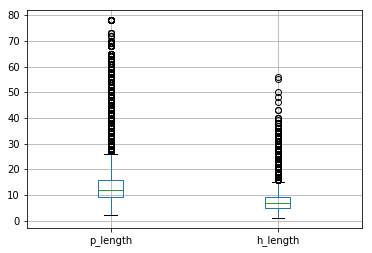

In [42]:
len_df = train_df[['p_length', 'h_length']]
display(len_df.describe(percentiles=[.25, .5, .75, .999]))
display(len_df.boxplot())



# Byte Pair Encoding
- Create a file with all of sentences contained in SNLI to train a *Byte-Pair Encoding*

In [4]:
premises = train_df['premise'].apply(lambda row : row.lower())
premises.column = ['text']
hypothesis = train_df['hypothesis'].apply(lambda row : row.lower())
hypothesis.column = ['text']
texts = pd.concat([premises, hypothesis])
display('Number of sentences: {}'.format(len(texts)))
texts.to_csv(r'.data/snli_sentences.txt', header=None, index=None)

'Number of sentences: 1098734'

/home/ichida/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  import sys


- Load test and val dataset and apply bpe into the sentences

In [5]:
import fastBPE
bpe_codes_path = '.data/codes.bpe'
bpe_vocab_path = '.data/vocab_20000.bpe'
val_path = '.data/snli-1.0-formatted-val.csv'
test_path = '.data/snli-1.0-formatted-test.csv'
val_df = pd.read_csv(val_path, sep='\t')
test_df = pd.read_csv(test_path, sep='\t')

bpe = fastBPE.fastBPE(bpe_codes_path, bpe_vocab_path)
bpe.apply(['this is sparta', 'this is spartial', 'this is parta'])

['this is s@@ part@@ a', 'this is spar@@ tial', 'this is part@@ a']

 ## Convert sentences to BPE format

In [14]:
def convert_to_bpe(df):
    bpe_df = pd.DataFrame()
    bpe_df['premise'] = df['premise'].astype(str).apply(lambda p: bpe.apply([p])[0])
    bpe_df['hypothesis'] = df['hypothesis'].astype(str).apply(lambda h: bpe.apply([h])[0])
    bpe_df['label'] = df['label']
    return bpe_df

train_bpe_df = convert_to_bpe(train_df)
train_bpe_df[:10]

,premise,hypothesis,label
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral
1,A person on a horse jumps over a broken down a...,"A person is at a din@@ er, ordering an ome@@ l...",contradiction
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
3,C@@ hi@@ ld@@ re@@ n smiling and waving at camera,T@@ he@@ y are smiling at their parents,neutral
4,C@@ hi@@ ld@@ re@@ n smiling and waving at camera,T@@ here are children present,entailment
5,C@@ hi@@ ld@@ re@@ n smiling and waving at camera,T@@ he kids are frowning,contradiction
6,A boy is jumping on skateboard in the middle o...,T@@ he boy skates down the sidewalk.,contradiction
7,A boy is jumping on skateboard in the middle o...,T@@ he boy does a skateboarding trick.,entailment
8,A boy is jumping on skateboard in the middle o...,T@@ he boy is wearing safety equipment.,neutral
9,A@@ n older man sits with his orange juice at ...,A@@ n older man drinks his juice as he waits f...,neutral



### BPE Sentence Length Analysis
- This analysis shows an aproximated max_len that we can use in a neural network while applying bpe

,p_length,h_length
count,549367.000000,549367.000000
mean,13.957861,8.470545
std,5.947488,3.381312
min,2.000000,1.000000
25%,10.000000,6.000000
50%,13.000000,8.000000
75%,17.000000,10.000000
99.9%,48.000000,28.000000
max,86.000000,79.000000


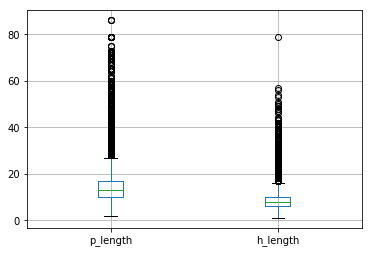

In [17]:
train_bpe_df['p_length'] = train_bpe_df['premise'].astype(str).apply(lambda row: len(row.split()))
train_bpe_df['h_length'] = train_bpe_df['hypothesis'].astype(str).apply(lambda row: len(row.split()))
len_bpe_df = train_bpe_df[['p_length', 'h_length']]
display(len_bpe_df.describe(percentiles=[.25, .5, .75, .999]))
display(len_bpe_df.boxplot())